# Final Project Report - Investigating the Effectiveness of Several Activation Functions and 3rd-Party Packages When Classifying 2015 Flight Delay Data

#### by Nick Malensek

## Overview

#### Objectives

The objectives of this study are: 
1. Test whether different activation functions make a measurable impact on the network's ability to classify data using the classifier neural network class developed during this course.
2. Classify the same data set using 3rd-party packages and their partitioning functions.

First, the data will be classified using the neural network developed during this course with a variety of activation functions. Then the effectiveness of the 3rd-party packages' solutions and their partitioning functions will also be examined. 3rd-party packages are frequently used to conduct machine learning and are expected to provide correct solutions, so it's important to evaluate their effectiveness at data preparation and machine-learning.

The classification results will be shown using confusion matrices. Investigation of data partitioning and the classification results will be done for each neural network configuration and then discussed.

#### Data Description

The data is provided by the US Department of Transportation (DOT). The DOT tracks on-time performance of domestic flights for all major carriers and records summary information about those flights on a yearly basis. Summary information includes things like scheduled and actual departure date/time and arrival date/time, origin airport, destination airport, and whether a flight was cancelled. Flight data for 2015 will be used for this study due to its relative timeliness and because it is easily available.

The data is formatted as comma-separated values, with the first line of the file containing the column headers. The following columns will be used as input: 

* Year
* Month
* Day
* Day of Week
* Airline
* Flight Number
* Tail Number (an airplane's unique ID)
* Origin Airport
* Destination Airport
* Scheduled Departure
* Elapsed Time
* Distance

The Arrival Delay column will be used to classify the data as early (arrival delay < 0), on-time (0 < arrival delay < 15), and late (arrival delay > 15) and the columns will be converted to a 0, 1, or 2, respectively.

The remaining columns are ignored because they are either not relevant to this study or contain information that would immediately classify a flight (Arrival Delay, for example). Cancelled flights will also not be considered for this study. Any columns that contain string data, like the Airline column, will be converted to an integer.

Finally, only flights from July will be considered for this study for all neural network experimentation. The original dataset had over 5 million records, so the stratified partitioning process alone took around 30 minutes. Additionally, it's unclear whether the inputs have any bearing on whether a flight's late. If the model has a difficult time predicting the classifications, evaluating one month initially avoids losing time on a model that may perform poorly no matter the number of records tested. July was selected as the month to study because it had the most flights, giving a good amount of data (~500,000) and significantly reducing processing time.

#### Activation Functions

##### Tanh

This is the baseline activation function that was used in this course and is commonly used in machine learning applications.

Formula:
$$
        \begin{align*}
          h_2(a) & = \tanh(a) = \frac{e^{a} - e^{-a}}{e^{a} + e^{-a}}
        \end{align*}
$$

Derivative:
$$
    \begin{align*}
    f'(x) = 1 - tanh^2(x)
    \end{align*}
$$

##### Leaky ReLu

Leaky ReLu is a modification of the ReLu activation function. The standard ReLu function can result in neurons that "die" by always returning 0 no matter what data is passed to them. Leaky ReLu attempts to alleviate this by multiplying the X value by a small number if it's less than 0 <sup>[1]</sup>. 0.01 was chosen as the small return value due to its widespread usage. This activation function was selected because it is an attempt to improve the ReLu function, which is generally regarded as a good activation function.

Formula:
$$
    \begin{align*}
        f(x) = (x < 0) (0.01(x)) + (x \geq 0)(x)
    \end{align*}
$$

Derivative:
$$
    \begin{align*}
        f'(x)=
    \begin{cases}
      1, & \text{if}\ x>0 \\
      0.01, & \text{otherwise}
    \end{cases}
    \end{align*}
$$

##### Softplus

Softplus was also chosen as an activation function because it is described in the Deep Learning textbook as an inferior activation function <sup>[2]</sup>. Most activation functions are selected because of their general good performance, so Softplus is used in this project as a "worst-case scenario" to give a broader perspective on how important activation functions are to the success of a neural network.

Formula:
$$
    \begin{align*}
        f(x)=\log(1+ e^x)
    \end{align*}
$$

Derivative:
$$
    \begin{align*}
        f'(x)= 1/(1 + e^{-x})
    \end{align*}
$$


#### 3rd-Party Packages

##### PyTorch

PyTorch is a popular Python package for conducting machine learning that simplifies the setup and execution of machine learning tasks, allowing a wider range of people to get involved in data science. Because it makes machine learning much more accessible, it is an important package to evaluate against the neural network developed in this course to ensure comparable results are possible with a "plug and play" solution.

The PyTorch network will use tanh as its activation function.

##### Spark MLlib

Spark is a machine learning package for use in distributed settings, so it's designed to efficiently analyze large datasets. The hypothesis is that designing a machine learning package to operate in a distributed setting requires a different design than a locally-used neural network, so its performance will be compared to the other networks' to investigate whether that's the case. Although it typically wouldn't be used to examine a dataset of this project's size, one of Spark's main features is its scalability, so theoretically it should achieve similar results no matter the file size.

The function used to analyze the data is MLlib's multilayer perceptron classifier (MLPC) function. Being a feed-forward neural network, MLPC can't directly be compared to the other networks, but it is the closest approximation in the MLlib package for data classification.

MLlib also provides its own partitioning function that will be used to partition the data during its run. The partitioning proportions will be examined to double-check that the data's being properly partitioned by this function.

According to Apache's documentation, intermediate layers use the Sigmoid function and the output layer uses the Softmax function.<sup>[3]</sup>

## Experimentation

### Imports

In [1]:
import neuralnetworksA4 as nn
import mlutilities as ml
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Code Definition

In [2]:
class LeakyClassifier(nn.NeuralNetworkClassifier):
    def activation(self, weighted_sum):
        return np.maximum(0.01, weighted_sum)
    def activationDerivative(self, activation_value):    
        return np.clip(activation_value > 0, 0.01, 1.0)

In [3]:
class SoftPlusClassifier(nn.NeuralNetworkClassifier):
    def activation(self, weighted_sum):
        return np.log(1 + np.exp(weighted_sum))
    def activationDerivative(self, activation_value):
        return (1/(1+np.exp(-activation_value)))

In [4]:
def percentCorrect(resultsMatrix, expectedMatrix):
    return np.sum(resultsMatrix.ravel()==expectedMatrix.ravel()) / float(len(expectedMatrix)) * 100

### Data import

In [5]:
airportsList = pandas.read_csv("airports.csv", usecols=[0])

In [6]:
airportsList.insert(0, 'airport_id', range(0, len(airportsList)))

In [7]:
airportsDictionary = {}
for row in airportsList.itertuples(index=False, name=None):
     airportsDictionary[row[1]] = row[0]
airportsDictionary

{'ABE': 0,
 'ABI': 1,
 'ABQ': 2,
 'ABR': 3,
 'ABY': 4,
 'ACK': 5,
 'ACT': 6,
 'ACV': 7,
 'ACY': 8,
 'ADK': 9,
 'ADQ': 10,
 'AEX': 11,
 'AGS': 12,
 'AKN': 13,
 'ALB': 14,
 'ALO': 15,
 'AMA': 16,
 'ANC': 17,
 'APN': 18,
 'ASE': 19,
 'ATL': 20,
 'ATW': 21,
 'AUS': 22,
 'AVL': 23,
 'AVP': 24,
 'AZO': 25,
 'BDL': 26,
 'BET': 27,
 'BFL': 28,
 'BGM': 29,
 'BGR': 30,
 'BHM': 31,
 'BIL': 32,
 'BIS': 33,
 'BJI': 34,
 'BLI': 35,
 'BMI': 36,
 'BNA': 37,
 'BOI': 38,
 'BOS': 39,
 'BPT': 40,
 'BQK': 41,
 'BQN': 42,
 'BRD': 43,
 'BRO': 44,
 'BRW': 45,
 'BTM': 46,
 'BTR': 47,
 'BTV': 48,
 'BUF': 49,
 'BUR': 50,
 'BWI': 51,
 'BZN': 52,
 'CAE': 53,
 'CAK': 54,
 'CDC': 55,
 'CDV': 56,
 'CEC': 57,
 'CHA': 58,
 'CHO': 59,
 'CHS': 60,
 'CID': 61,
 'CIU': 62,
 'CLD': 63,
 'CLE': 64,
 'CLL': 65,
 'CLT': 66,
 'CMH': 67,
 'CMI': 68,
 'CMX': 69,
 'CNY': 70,
 'COD': 71,
 'COS': 72,
 'COU': 73,
 'CPR': 74,
 'CRP': 75,
 'CRW': 76,
 'CSG': 77,
 'CVG': 78,
 'CWA': 79,
 'DAB': 80,
 'DAL': 81,
 'DAY': 82,
 'DBQ': 83,
 '

In [8]:
airlinesList = pandas.read_csv("airlines.csv")
airlinesList.insert(0, 'airline_id', range(0, len(airlinesList)))
airlinesList
airlinesDictionary = {}
for row in airlinesList.itertuples(index=False, name=None):
     airlinesDictionary[row[1]] = row[0]
airlinesDictionary

{'AA': 1,
 'AS': 6,
 'B6': 4,
 'DL': 9,
 'EV': 10,
 'F9': 3,
 'HA': 11,
 'MQ': 12,
 'NK': 7,
 'OO': 5,
 'UA': 0,
 'US': 2,
 'VX': 13,
 'WN': 8}

In [12]:
convertAirports = {4: lambda a: float(airlinesDictionary[a]), 7: lambda o: float(airportsDictionary[o]), 8: lambda d: float(airportsDictionary[d])}

In [13]:
originalFlightData = pandas.read_csv("flights.csv", usecols=[0,1,2,3,4,5,6,7,8,9,15,17,22,24], converters = convertAirports, skiprows=lambda x: x in range(4385713, 4871878))

In [14]:
tailNumberList = []
for row in originalFlightData.itertuples(index=False, name=None):
    if row[6] not in tailNumberList:
        tailNumberList.append(row[6])

In [15]:
tailNumberDictionary = {}
i = 1.0
for tailNumber in tailNumberList:
    tailNumberDictionary[tailNumber] = i
    i = i + 1
tailNumberDictionary[''] = 0.0

In [16]:
def convertDelay(time):
    time = float(time)
    if time < 0:
        return 0.0 
    if time > 0 and time < 15:
        return 1.0
    if time > 15:
        return 2.0

In [17]:
convertData = {4: lambda a: float(airlinesDictionary[a]), 6: lambda i: float(tailNumberDictionary[i]), 7: lambda o: float(airportsDictionary[o]), 8: lambda d: float(airportsDictionary[d])}

In [18]:
convertedFlightData = pandas.read_csv("flights.csv", usecols=[0,1,2,3,4,5,6,7,8,9,15,17,22,24], converters = convertData, skiprows=lambda x: x in range(4385713, 4871878))

In [19]:
for i in range(1, 13):
    test = convertedFlightData.loc[convertedFlightData['MONTH'] == i]
    print(i, test.shape)

1 (469968, 14)
2 (429191, 14)
3 (504312, 14)
4 (485151, 14)
5 (496993, 14)
6 (503897, 14)
7 (520718, 14)
8 (510536, 14)
9 (464946, 14)
10 (0, 14)
11 (467972, 14)
12 (479230, 14)


In [20]:
#Keep only non-cancelled flights, drop cancelled column, convert everything to a float, 
#convert arrival delay to classifications, keep only June flight data to keep processing time reasonable.
convertedFlightData = convertedFlightData[convertedFlightData.CANCELLED != 1]
convertedFlightData = convertedFlightData.drop(['CANCELLED'], axis=1)
convertedFlightData = pandas.DataFrame(convertedFlightData, dtype='float')
convertedFlightData['ARRIVAL_DELAY'] = convertedFlightData['ARRIVAL_DELAY'].map(lambda x: convertDelay(x))
julyData = convertedFlightData.loc[convertedFlightData['MONTH'] == 7.0]

In [21]:
julyData.to_csv('~/Desktop/julyData.csv')

In [22]:
X = julyData.drop(['ARRIVAL_DELAY'], axis=1)
T = julyData[['ARRIVAL_DELAY']]
XMatrix = np.array(X)
TMatrix = np.array(T)
XMatrix.shape, TMatrix.shape

((515912, 12), (515912, 1))

### CS445 Neural Network Analysis

In [23]:
early = np.where(TMatrix == 0)
onTime = np.where(TMatrix == 1)
late = np.where(TMatrix == 2)
print('% Early: ', ((early[0].size)/TMatrix.size * 100))
print('% On Time: ', ((onTime[0].size)/TMatrix.size * 100))
print('% Late: ', ((late[0].size)/TMatrix.size * 100))

% Early:  58.79839972708524
% On Time:  17.849943401200203
% Late:  20.152080199723983


In [24]:
x_train, t_train, x_test, t_test = ml.partition(XMatrix, TMatrix, 0.8, shuffle=True, classification=True)

In [25]:
x_train.shape, t_train.shape, x_test.shape, t_test.shape

((399524, 12), (399524, 1), (99881, 12), (99881, 1))

In [26]:
tEarly = np.where(t_test == 0)
tOnTime = np.where(t_test == 1)
tLate = np.where(t_test == 2)
print('% Early: ', ((tEarly[0].size)/t_test.size * 100))
print('% On Time: ', ((tOnTime[0].size)/t_test.size * 100))
print('% Late: ', ((tLate[0].size)/t_test.size * 100))

% Early:  60.742283317147404
% On Time:  18.439943532804037
% Late:  20.81777315004856


#### Tanh Confusion Matrices and Plot

In [27]:
x_train, t_train, x_test, t_test = ml.partition(XMatrix, TMatrix, 0.8, shuffle=True, classification=True)
neuralNet = nn.NeuralNetworkClassifier(x_train.shape[1], 100, len(np.unique(t_train)))
neuralNet.train(x_train, t_train)
trainPredictions = neuralNet.use(x_train)
testPredictions = neuralNet.use(x_test)
print('Tanh results:')
ml.confusionMatrix(t_train, trainPredictions, [0, 1, 2])
print('Training - 100 iterations, 100 hidden units: ', percentCorrect(trainPredictions, t_train), '% correct')
ml.confusionMatrix(t_test, testPredictions, [0, 1, 2])
print('Testing - 100 iterations, 100 hidden units: ', percentCorrect(testPredictions, t_test), '% correct')

Tanh results:
       0    1    2
    ------------------
 0 | 94.8  0.9  4.3
 1 | 74.9  6.1 19.0
 2 | 62.5  3.3 34.2
Training - 100 iterations, 100 hidden units:  65.80180414693486 % correct
       0    1    2
    ------------------
 0 | 94.6  0.9  4.5
 1 | 75.3  6.2 18.5
 2 | 62.8  3.2 34.0
Testing - 100 iterations, 100 hidden units:  65.6661427098247 % correct


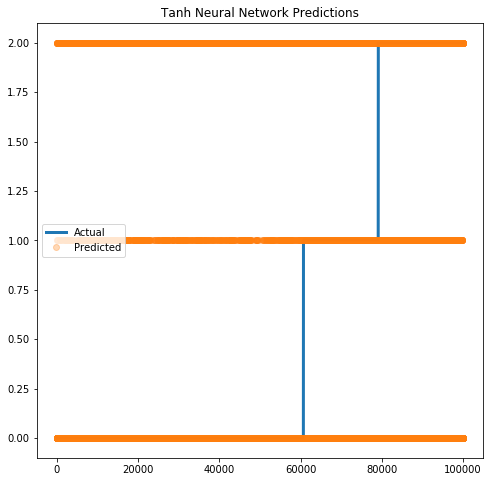

In [28]:
plt.figure(figsize=(8,8))
plt.title('Tanh Neural Network Predictions')
plt.plot(t_test,lw=3)
plt.plot(testPredictions,'o',alpha=0.3)
plt.legend(('Actual','Predicted'), loc='best');

#### Leaky ReLU Confusion Matrices and Plot

In [39]:
x_train, t_train, x_test, t_test = ml.partition(XMatrix, TMatrix, 0.8, shuffle=True, classification=True)
leakyNeuralNet = LeakyClassifier(x_train.shape[1], 100, len(np.unique(t_train)))
leakyNeuralNet.train(x_train, t_train)
leakyTrainPredictions = leakyNeuralNet.use(x_train)
leakyTestPredictions = leakyNeuralNet.use(x_test)
print('Leaky ReLu results: ')
ml.confusionMatrix(t_train, leakyTrainPredictions, [0, 1, 2])
print('Training - 100 iterations, 100 hidden units: ', percentCorrect(leakyTrainPredictions, t_train), '% correct')
ml.confusionMatrix(t_test, leakyTestPredictions, [0, 1, 2])
print('Testing - 100 iterations, 100 hidden units: ', percentCorrect(leakyTestPredictions, t_test), '% correct')

Leaky ReLu results: 
       0    1    2
    ------------------
 0 | 95.2  0.5  4.3
 1 | 79.6  3.4 16.9
 2 | 66.9  2.8 30.3
Training - 100 iterations, 100 hidden units:  64.7840930707542 % correct
       0    1    2
    ------------------
 0 | 95.2  0.4  4.3
 1 | 79.4  3.3 17.3
 2 | 66.7  2.5 30.8
Testing - 100 iterations, 100 hidden units:  64.86018361850601 % correct


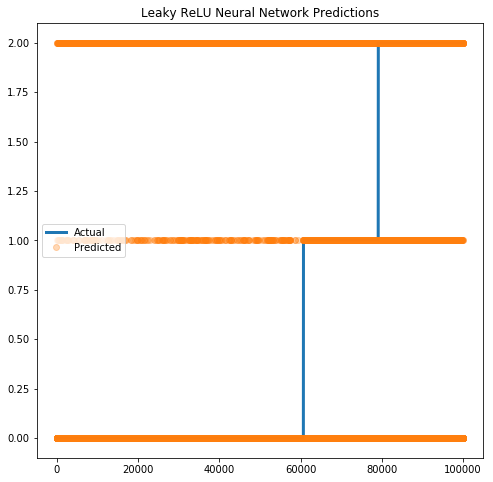

In [40]:
plt.figure(figsize=(8,8))
plt.title('Leaky ReLU Neural Network Predictions')
plt.plot(t_test,lw=3)
plt.plot(leakyTestPredictions,'o',alpha=0.3)
plt.legend(('Actual','Predicted'), loc='best');

#### Softplus Confusion Matrices and Plot

In [41]:
x_train, t_train, x_test, t_test = ml.partition(XMatrix, TMatrix, 0.8, shuffle=True, classification=True)
softplusNeuralNet = SoftPlusClassifier(x_train.shape[1], 100, len(np.unique(t_train)))
softplusNeuralNet.train(x_train, t_train)
softTrainPredictions = softplusNeuralNet.use(x_train)
softTestPredictions = softplusNeuralNet.use(x_test)
print('Softplus results:')
ml.confusionMatrix(t_train, softTrainPredictions, [0, 1, 2])
print('Training - 100 iterations, 100 hidden units: ', percentCorrect(softTrainPredictions, t_train), '% correct')
ml.confusionMatrix(t_test, softTestPredictions, [0, 1, 2])
print('Testing - 100 iterations, 100 hidden units: ', percentCorrect(softTestPredictions, t_test), '% correct')

Softplus results:
       0    1    2
    ------------------
 0 | 95.3  0.1  4.6
 1 | 80.0  1.1 18.8
 2 | 66.8  1.2 32.0
Training - 100 iterations, 100 hidden units:  64.74679869044162 % correct
       0    1    2
    ------------------
 0 | 95.2  0.1  4.7
 1 | 80.3  1.2 18.5
 2 | 67.1  1.2 31.7
Testing - 100 iterations, 100 hidden units:  64.66094652636639 % correct


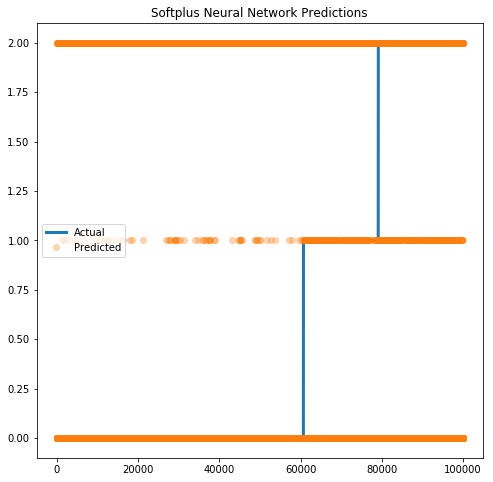

In [42]:
plt.figure(figsize=(8,8))
plt.title('Softplus Neural Network Predictions')
plt.plot(t_test,lw=3)
plt.plot(softTestPredictions,'o',alpha=0.3)
plt.legend(('Actual','Predicted'), loc='best');

### PyTorch Neural Network Analysis

In [66]:
import torch
import torch.nn as tnn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as tdata

class Net(tnn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = tnn.Linear(12, 100)
        self.fc2 = tnn.Linear(100, 100)
        self.fc3 = tnn.Linear(100, 3)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    

net = Net()

criterion = tnn.CrossEntropyLoss() #Combines logsoftmax and negative log likelihood into one function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #SGD

#Transform data into PyTorch tensors.
torchTrainData = tdata.TensorDataset(torch.from_numpy(x_train).float(), torch.squeeze(torch.from_numpy(t_train).float()))
trainLoader = tdata.DataLoader(torchTrainData, batch_size=1, shuffle=True)

torchTestData = tdata.TensorDataset(torch.from_numpy(x_test).float(), torch.squeeze(torch.from_numpy(t_test).float()))
testLoader = tdata.DataLoader(torchTestData, batch_size=1, shuffle=True)

In [67]:
#Train loop
Iterations = 3
for iteration in range(Iterations):
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 40000 == 39999:    # print every 100000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (iteration + 1, i + 1, running_loss / 40000))
            running_loss = 0.0

print('Finished Training')

[1, 40000] loss: 0.944
[1, 80000] loss: 0.945
[1, 120000] loss: 0.945
[1, 160000] loss: 0.941
[1, 200000] loss: 0.946
[1, 240000] loss: 0.948
[1, 280000] loss: 0.939
[1, 320000] loss: 0.940
[1, 360000] loss: 0.945
[2, 40000] loss: 0.947
[2, 80000] loss: 0.942
[2, 120000] loss: 0.948
[2, 160000] loss: 0.945
[2, 200000] loss: 0.948
[2, 240000] loss: 0.942
[2, 280000] loss: 0.941
[2, 320000] loss: 0.935
[2, 360000] loss: 0.939
[3, 40000] loss: 0.946
[3, 80000] loss: 0.940
[3, 120000] loss: 0.941
[3, 160000] loss: 0.941
[3, 200000] loss: 0.944
[3, 240000] loss: 0.941
[3, 280000] loss: 0.944
[3, 320000] loss: 0.944
[3, 360000] loss: 0.941
Finished Training


In [68]:
correct = 0
total = 0
predictions = []
with torch.no_grad():
    for data in testLoader:
        flights, labels = data
        outputs = net(flights)
        _, predicted = torch.max(outputs.data, 1)
        predictions.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels.long()).sum().item()

print('Accuracy of the network on the test flights: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test flights: 60 %


In [69]:
#print confusion matrix
classes = ('early', 'on time', 'late')
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
predictions = []
with torch.no_grad():
    for data in testLoader:
        flights, labels = data
        labels = labels.long()
        outputs = net(flights)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        predictions.append(predicted)
        for i in range(4):
            label = labels.item()
            class_correct[label] += c.sum().item()
            class_total[label] += 1

In [70]:
for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    print(class_correct[i], ' correct out of ', class_total[i])

Accuracy of early : 100 %
242680.0  correct out of  242680.0
Accuracy of on time :  0 %
0.0  correct out of  73672.0
Accuracy of  late :  0 %
0.0  correct out of  83172.0


In [71]:
pyTorchPredictions = np.array(predictions)

#### PyTorch Confusion Matrices and Plot

In [72]:
ml.confusionMatrix(t_test, pyTorchPredictions, [0, 1, 2])

       0    1    2
    ------------------
 0 |100.0  0    0  
 1 |100.0  0    0  
 2 |100.0  0    0  


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

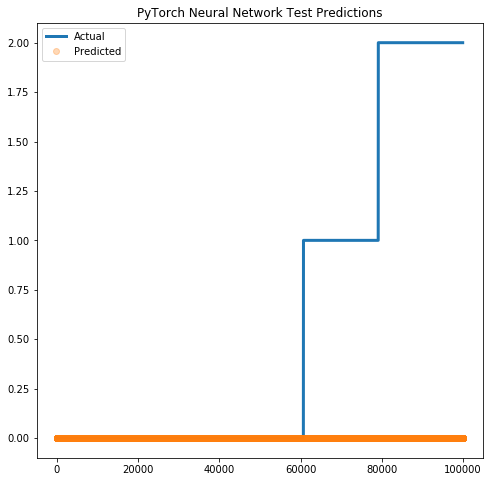

In [81]:
plt.figure(figsize=(8,8))
plt.plot(t_test,lw=3)
plt.plot(pyTorchPredictions,'o',alpha=0.3)
plt.title('PyTorch Neural Network Test Predictions')
plt.legend(('Actual','Predicted'), loc='best');

### Spark Neural Network Analysis

Copy and paste below text into a PySpark shell to execute.

import pandas as pd<br>
from pyspark.ml.classification import MultilayerPerceptronClassifier<br>
from pyspark.ml.evaluation import MulticlassClassificationEvaluator<br>
from pyspark.mllib.util import MLUtils<br>
from pyspark.mllib.regression import LabeledPoint<br>
<br>
spark = SparkSession.builder.getOrCreate()<br>
julyData = pd.read_csv('../julyData.csv')<br>
<br>
julyData = julyData.drop(['Unnamed: 0'], axis=1) #Drop auto-generated columns.<br>
<br>
#Spark reads in some numbers as NaN even though this is the same file as used for the other experiments, so drop NaNs.<br>
julyData = julyData.dropna()<br>
julyData.count()<br>
499405<br>
<br>
sparkJuly = spark.createDataFrame(julyData) #convert from Pandas dataframe to Spark dataframe for easier mapping + saving.<br>
<br>
julyRDD = sparkJuly.rdd #convert to an RDD to allow mapping the data to Labeled Point objects<br>
<br>
julyRDD.take(1)<br>
[Row(YEAR=2015.0, MONTH=7.0, DAY=1.0, DAY_OF_WEEK=3.0, AIRLINE=7.0, FLIGHT_NUMBER=298.0, TAIL_NUMBER=3708.0, ORIGIN_AIRPORT=174.0, DESTINATION_AIRPORT=151.0, SCHEDULED_DEPARTURE=3.0, ELAPSED_TIME=179.0, DISTANCE=1222.0, ARRIVAL_DELAY=2.0)]<br>
<br>
#Map data to labeled points as tuple of (classification, [features])<br>
julyLP = julyRDD.map(lambda line: LabeledPoint(line[12], line[:12]))<br>
<br>
julyLP.take(1)<br>
[LabeledPoint(1.0, [2015.0,7.0,15.0,3.0,0.0,756.0,367.0,149.0,85.0,828.0,236.0,1452.0])]<br>
<br>
#Coalesce data into one partition, otherwise Spark will write out 15 files instead of 1.<br>
coaJulyLP = julyLP.coalesce(1)<br>
<br>
#Save as SVM files, which Spark requires for its neural networks. <br>
#Format: classification 1:feature 1 value 2:feature 2 value ... n:feature n value<br>
MLUtils.saveAsLibSVMFile(coaJulyLP, "../julyData")<br>
<br>
finalData = spark.read.format("libsvm").load("../julyData/part-00000")<br>
<br>
#randomly split data, unclear if proportion of each classification is maintained<br>
#more information here: https://stackoverflow.com/questions/32933143/how-does-sparks-rdd-randomsplit-actually-split-the-rdd<br>
splits = finalData.randomSplit([0.8, 0.2], 1234)<br>
train = splits[0]<br>
test = splits[1]<br>
<br>
#12 input features, 100 hidden units, 3 output<br>
layers = [12, 100, 3]<br>
<br>
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234, stepSize=0.001)<br>
<br>
model = trainer.fit(train)<br>
result = model.transform(test)<br>
resultPD = result.toPandas()<br>
resultPD.to_csv("../resultsCSV")<br>
<br>
result.show()<br>
<br>
+-----+--------------------+----------+<br>
|label|            features|prediction|<br>
+-----+--------------------+----------+<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
|  0.0|(12,[0,1,2,3,4,5,...|       0.0|<br>
+-----+--------------------+----------+<br>
only showing top 20 rows<br>
            <br>
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")<br>
predictionAndLabels = result.select("prediction", "label")<br>
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)*100) + "%")<br>

### Test set accuracy = 60.668957296122294%

#### Partitioning Evaluation

#train<br>
tZeroes = train.where(train['label'] == 0.0)<br>
tZeroes.count()<br>
242775 <br>

tOnes = train.where(train['label'] == 1.0)<br>
tOnes.count()<br>
73592<br>  

tTwos = train.where(train['label'] == 2.0)<br>
tTwos.count()<br>
83211 <br>

#test<br>
zeroes = test.where(test['label'] == 0.0)<br>
zeroes.count()<br>
60573    <br>

ones = test.where(test['label'] == 1.0)<br>
ones.count()<br>
18498  <br>

twos = test.where(test['label'] == 2.0)<br>
twos.count()<br>
20756<br>

#### Verifying the original classification proportions were maintained by Spark's randomSplit method

In [74]:
trainCount = 242775 + 73592 + 83211
train0 = 242775/trainCount
train1 = 73592/trainCount
train2 = 83211/trainCount
trainCount, train0, train1, train2

(399578, 0.6075784953125547, 0.1841743038906046, 0.20824720079684067)

In [75]:
testCount = 60573 + 18498 + 20756
test0s = 60573
test1s = 18498
test2s = 20756
testCount, test0s/testCount, test1s/testCount, test2s/testCount

(99827, 0.6067797289310507, 0.1853005699860759, 0.20791970108287336)

In [76]:
totalCount = trainCount + testCount
totalCount

499405

#### Test Data Accuracy Evaluation

#### Spark Test data analysis

In [82]:
sparkResults = pandas.read_csv("resultsCSV")
sparkResults = sparkResults.sort_values(by=['label'])
sparkResults

,Unnamed: 0,label,features,prediction
0,0,0.0,"(12,[0,1,2,3,4,5,6,7,8,9,10,11],[2015.0,7.0,1....",0.0
35017,35017,0.0,"(12,[0,1,2,3,4,5,6,7,8,9,10,11],[2015.0,7.0,5....",0.0
35018,35018,0.0,"(12,[0,1,2,3,4,5,6,7,8,9,10,11],[2015.0,7.0,5....",0.0
35019,35019,0.0,"(12,[0,1,2,3,4,5,6,7,8,9,10,11],[2015.0,7.0,5....",0.0
35020,35020,0.0,"(12,[0,1,2,3,4,5,6,7,8,9,10,11],[2015.0,7.0,5....",0.0
35021,35021,0.0,"(12,[0,1,2,3,4,5,6,7,8,9,10,11],[2015.0,7.0,5....",0.0
35022,35022,0.0,"(12,[0,1,2,3,4,5,6,7,8,9,10,11],[2015.0,7.0,5....",0.0
35023,35023,0.0,"(12,[0,1,2,3,4,5,6,7,8,9,10,11],[2015.0,7.0,5....",0.0
35024,35024,0.0,"(12,[0,1,2,3,4,5,6,7,8,9,10,11],[2015.0,7.0,5....",0.0
35025,35025,0.0,"(12,[0,1,2,3,4,5,6,7,8,9,10,11],[2015.0,7.0,5....",0.0


In [83]:
actualLabels = np.array(sparkResults['label'])
predictedLabels = np.array(sparkResults['prediction'])

#### Spark Confusion Matrices and Plot

In [84]:
ml.confusionMatrix(actualLabels, predictedLabels, [0, 1, 2])

       0    1    2
    ------------------
 0 |100.0  0    0.0
 1 | 99.9  0    0.1
 2 | 99.9  0    0.1


array([[9.99588037e-01, 0.00000000e+00, 4.11963418e-04],
       [9.99387797e-01, 0.00000000e+00, 6.12203251e-04],
       [9.99096059e-01, 0.00000000e+00, 9.03941184e-04]])

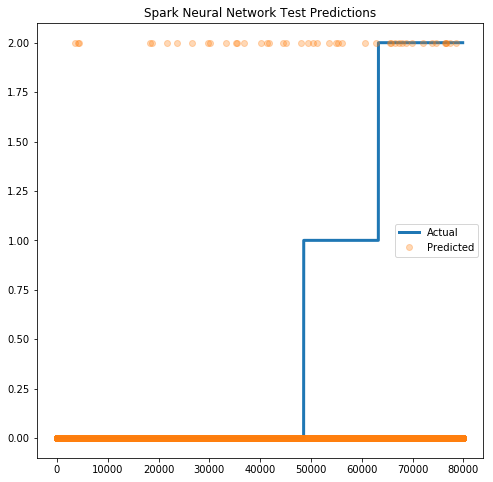

In [85]:
plt.figure(figsize=(8,8))
plt.plot(actualLabels,lw=3)
plt.plot(predictedLabels,'o',alpha=0.3)
plt.title('Spark Neural Network Test Predictions')
plt.legend(('Actual','Predicted'), loc='best');

## Conclusions and Future Work

### CS445 Neural Network Results Discussion

The neural network we developed in class had relatively similar performance between all three tested activation functions. As shown above, networks using tanh, leaky ReLU, or Softplus all achieved roughly 65-66% accuracy on the test data. Fluctuations in accuracy between the different activations functions was minor, and could be attributed to the fact that only one random partitioning of the data was performed for each one.

All three networks favored predicting 0 ('early') as a particular flight's classification, but did manage to classify some non-early flights correctly.

Of the three activation functions, tanh continues to be a solid choice, yielding around .5-1% higher accuracy than the other two functions depending on the data split. Interestingly, softplus didn't perform that much worse on this dataset despite our textbook's description of it as an inferior activation function. Overall though, changing the activation function didn't make a huge difference in the results for this data set.

These neural networks were able to correctly predict when a flight was going to be late 30% of the time but unfortunately tended to mis-classify late flights as early. If you're a passenger on a flight that's going to be delayed, the last thing you want is to be told the flight's going to arrive early. In spite of that, these networks far outperformed the Spark and PyTorch networks in predicting late flights.

### PyTorch Neural Network Results Discussion

#### Usability

PyTorch was interesting to work with because a neural network ends up being constructed of fairly modular components. It allows for more concrete fine-tuning compared to the CS445 neural networks, because method calls can be easily replaced to alter the characteristics of the network. The downside to this is the learning curve ends up being higher and it's easier to create a network with suboptimal parameters. For example, some tutorials used a sigmoid function for the final forward pass, while others just returned the un-transformed value. It took some digging through the PyTorch documentation to figure out that one was using a negative log likelihood function afterward, while the other was using a Cross Entropy Loss function that performs the sigmoid and negative log likelihood functions in one call. The end result was the same, but the wide range of available functions increase the likelihood of making a mistake.

Comparatively, all the user needs to do with the CS445 network is create it, tell it the inputs, hidden layers, and outputs, and the network takes care of the rest. Of course, there are additional parameters to tweak if required, but the default settings apply very well in general. PyTorch also requires the user to write much more code than our neural networks; creating, using, and evaluating a neural network involved writing at least one loop at each step.

The CS445 partitioning function was used to partition the data for the PyTorch network because the PyTorch network accepted numpy arrays for the train and test set. In addition to being simple to implement, that function was also used because it appears a function for stratified partitioning is not available in PyTorch<sup>[4]</sup>.

#### Results

PyTorch guessed 0/'early' for all flights in the dataset. The network used tanh as the activation function and sigmoid/negative log likelihood during the backward pass like the CS445 networks, so it's unclear why it was unable to predict anything other than a 0. Every effort was made to use the same parameters as the ones used in the CS445 networks to enable a direct comparison. The most likely explanation is an accidental parameter change or suboptimal configuration in the PyTorch network because of my inexperience with the package. Another possible explanation is that PyTorch's neural network implementation may be more sensitive to the problems with the data that are discussed below than the CS445 networks.

### Spark Neural Network Results Discussion

#### Usability

Spark was very simple to install, and most exceptions encountered during use were easily resolved by adding import statements. Once everything was installed, the main challenge was converting the data from a .csv file to a libsvm file, which is required by some of Spark's machine learning classes. Unfortunately, there was no official documentation or tutorial to do so. Because of this, reformatting the data formed the bulk of the work and troubleshooting during this phase, so the initial complexity was much higher compared to PyTorch.

Once the initial challenge of creating a libsvm file was overcome, using Spark's Multilayer Perceptron Classifier (MLPC) class was incredibly easy. The amount of work required was similar to the CS445 networks: instantiate a network, give it the inputs, hidden layers, and outputs, and the network does the rest. Spark provided a partitioning function as equally easy to use as the one developed in class, and it correctly maintains the proportions of the different classifications in the train and test set. Additionally, the MLPC class exposes a number of parameters to allow tuning, but provides usable default values for most of them. This allows new users to pick up and use the MLPC class without much effort, but also provides the option of fine-tuning once the user has more experience.

Another drawback to using Spark's MLPC class is that the trained model is returned as an MLPC model object. The user's investigation of the training set accuracy is therefore constrained to the methods provided by that object, which generally focus on providing information about the network parameters and not the training results<sup>[5]</sup>. Test results, in contrast, are returned as a dataframe and are much easier to work with and evaluate. This drawback isn't critical because the test results are what really matters, but it still would have been nice to see some intermediate data to have an idea of how well the model's learning.

#### Results

Similarly to PyTorch, the MLPC tended to classify flights as 0/'early' no matter the input values. The network used a sigmoid function in the intermediate layers and a softmax in the output layer<sup>[3]</sup>. Sigmoid's output range is [0, 1], compared to tanh's [-1, 1] so that may have changed the output slightly compared to PyTorch's use of tanh. This small difference could be why the network occasionally predicted 2/'late' classifications whereas the PyTorch networks did not. Unfortunately, it's difficult to say what the reason behind the occasional 2/'late' classification is without access to the code, but it could have also been a problem with the data as mentioned below.

Overall, Spark performed slightly better than PyTorch but worse than the CS445 networks. Since Spark's claim to fame is its ability to process massive datasets quickly, it's worth investigating further since it may be able to analyze data sets that have not been tested much due to their sheer size.

### General Conclusions

All neural networks used in this study had difficulty classifying flights as anything other than 0 ('early') and all achieved roughly 60% test accuracy. 

There could be several explanations for this behavior, the simplest being that the data was skewed to 'early' classifications. Roughly 60% of the data's actual classification was 'early', so the networks may have quickly learned to always predict 'early'/0.

Another explanation could be that the features included in the dataset have little to no bearing on the outcome of the flight. This could be reasonable considering that, according to Business Insider, 50% of delays are caused by "airline issues" (aircraft maintenance, crew scheduling, etc.), 30% are caused by weather, and 15% are caused by general US Aviation issues<sup>[4]</sup>. Because 45% are outside of the airline's control and 50% are controlled by the airline but may not necessarily cause consistent delays, the features examined may not have a direct correlation to the probability of a flight being delayed.

The final explanation could be that there was an error setting up one or more of the networks. This is relatively unlikely for the neural network we created in class, as the data and process was similar to what we've done before. It's difficult to say whether this was part of the problem for the PyTorch and Spark experiments. Due to my relative inexperience with both packages some configuration parameters may not have been optimized, but the networks used in the experiments were created following the official tutorials. These should (hopefully) provide good instruction, decreasing the chance that the inaccuracy was caused by improper setup.

Based on the networks' behavior and class discussions, the second reason is likely the reason for the overall inaccuracy.

For the data analyzed, the CS445 neural networks performed best with an accuracy level around 65% compared to PyTorch and Spark's accuracy of around 60%.

Changing the activation function for the CS445 networks had relatively little impact on the final results for this data set. Tanh performed slightly better and performed well on most data sets examined during this course, so it seems like a good starting point for most networks and data sets.

### Future Work

This data set could be analyzed further to investigate the cause of some of the problems mentioned above. The first and simplest next step would be to partition the data in a way that all three classifications are equally represented in the data. It would then be easier to evaluate how well the networks are doing and whether it's possible to accurately predict whether a flight's going to be late based on the inputs.

If using unskewed data vastly improves results, the next step could be evaluating the entire dataset instead of one month.

Default parameters were generally favored during this study except when the defaults differed between packages (Spark's default step size/learning rate is 0.03, for example). This study could be repeated with different neural network parameters to gauge how much each parameter influences results.

Finally, additional machine learning packages, such as Microsoft's CNTK, could also be used to evaluate this data set.

## References

1. http://cs231n.github.io/neural-networks-1/
2. Deep Learning, Goodfellow et-al. 2016 (http://www.deeplearningbook.org)
3. https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier
4. https://github.com/pytorch/pytorch/issues/5231
5. http://www.businessinsider.com/why-your-flight-delayed-2016-12
6. https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.MultilayerPerceptronClassifier